# Grand Circus Final Project
### Car Crash and Safety Data Comparisons/Evaluations

This project aims to compare safety ratings from crash tests to actual data of fatal crashes. The use of fatal crash data is better suited for hard crashes where occupant life is and was in danger, providing more relevant data entries compared to fender benders or other minimal 'traffic incidents'. This analysis could be useful for car buyers, car manufactureres, government testers, and insurance companies.

## Extraction
To start the ETA process, data but be extracted and placed into usable structures. To do this, we will be importing the data from the api(s) and any other flat file sources.

In [3]:
import pandas as pd
import requests
import json
import os.path
import tqdm

# Begin pulling make names and ID's for internal use
# Definitions endpoint query
make_url = "https://crashviewer.nhtsa.dot.gov/CrashAPI/definitions/GetVariableAttributes?variable=make&caseYear=2021&format=json"

if os.path.isfile("./data/GetVariableAttributes_Make.json"):
     with open('./data/GetVariableAttributes_Make.json', 'r') as openfile:
        data = json.load(openfile)
else:
    # Get response
    response = requests.get(make_url)
    # Turn response into json
    data = response.json()

In [4]:
#Drill down json to list of dictionary
results = data['Results'][0]

In [5]:
# split data into lists
id_list = []
name_list = []
for entry in results:
    id_list.append(int(entry['ID']))
    name_list.append(entry['TEXT'])

# Make columns dictionary based on lists
data = {'MakeID': id_list, 'Name': name_list}

# Create df using dictionary
manufacturer_df = pd.DataFrame(data)

# Sort by Id instead of name
manufacturer_df = manufacturer_df.sort_values(by=['MakeID'])
manufacturer_df.head()

,MakeID,Name
3,1,American Motors
38,2,Jeep / Kaiser-Jeep / Willys- Jeep
2,3,AM General
13,6,Chrysler
18,7,Dodge


## Only Taking Top 11 Best-Selling Makes
Since the API contains data for all involved in crashes, such as the American Motors Ambassador made from 1952-1974, a fair portion of vehicles are not statistically relevant, or would be outwighed by more common vehicles. To prevent a weighting issing where more prevalent vehicles scew results to thinking more crashes are common, we will be using some of the most popular makes only.

In [7]:
to_keep = ['Nissan/Datsun', 'Toyota', 'KIA', 'Honda', 'Subaru', 'Ford', 'Chevrolet', 'Hyundai', 'Jeep / Kaiser-Jeep / Willys- Jeep', 'GMC', 'Dodge']
new_df = manufacturer_df[manufacturer_df['Name'].isin(to_keep)]
manufacturer_df = new_df
manufacturer_df.rename(columns={'Name': 'MakeName'}, inplace=True)
manufacturer_df.head(15)

,MakeID,MakeName
38,2,Jeep / Kaiser-Jeep / Willys- Jeep
18,7,Dodge
23,12,Ford
12,20,Chevrolet
27,23,GMC
55,35,Nissan/Datsun
30,37,Honda
73,48,Subaru
76,49,Toyota
31,55,Hyundai


### Fetching Model IDs

In [9]:
import time

all_models = []

for make_ID in manufacturer_df['MakeID']:
    if os.path.isfile(f"./data/GetVariableAttributesForModel_{make_ID}.json"):
        with open(f"./data/GetVariableAttributesForModel_{make_ID}.json", 'r') as openfile:
            data = json.load(openfile)
            results_model = data.get('Results')
            for model in results_model:
                all_models.append({
                    'MakeID': make_ID,
                    'Models': model[0:]
                })
    else:
        model_url = f'https://crashviewer.nhtsa.dot.gov/CrashAPI/definitions/GetVariableAttributesForModel?variable=model&caseYear=2021&make={make_ID}&format=json'
        response = requests.get(model_url)
        model_data = response.json()
        
        results_model = model_data.get('Results') 
    
        time.sleep(1)
        for model in results_model:
            all_models.append({
                'MakeID': make_ID,
                'Models': model[0:]
            })
# Drill down into JSON
drill_down = all_models[0]['Models']
drill_down

[{'ID': 404,
  'MODELNAME': 'Cherokee (1984-on) (For Grand Cherokee for 2014 on use 02-422.)',
  'Make': None},
 {'ID': 421, 'MODELNAME': 'Cherokee (thru 1983)', 'Make': None},
 {'ID': 401, 'MODELNAME': 'CJ-2/CJ-3/CJ-4', 'Make': None},
 {'ID': 402, 'MODELNAME': 'CJ-5/CJ-6/CJ-7/CJ-8', 'Make': None},
 {'ID': 482, 'MODELNAME': 'Comanche', 'Make': None},
 {'ID': 406, 'MODELNAME': 'Commander', 'Make': None},
 {'ID': 1, 'MODELNAME': 'Compass', 'Make': None},
 {'ID': 483, 'MODELNAME': 'Gladiator', 'Make': None},
 {'ID': 422,
  'MODELNAME': 'Grand Cherokee (For 2014 on.  Use model 404 for model years prior to 2013.)',
  'Make': None},
 {'ID': 431, 'MODELNAME': 'Grand Wagoneer', 'Make': None},
 {'ID': 405, 'MODELNAME': 'Liberty', 'Make': None},
 {'ID': 498, 'MODELNAME': 'Other (light truck)', 'Make': None},
 {'ID': 407, 'MODELNAME': 'Patriot', 'Make': None},
 {'ID': 481, 'MODELNAME': 'Pick-up', 'Make': None},
 {'ID': 408, 'MODELNAME': 'Renegade', 'Make': None},
 {'ID': 999, 'MODELNAME': 'Unknow

In [10]:
models_df = pd.DataFrame(all_models).sort_values(by='MakeID')

In [11]:
# Merge manufacturer_df & models_df
merged_df = pd.merge(manufacturer_df, models_df, on="MakeID", how="left")
merged_df = merged_df.sort_values(by='MakeID')

In [12]:
# Explode the Models column to separate rows
exploded_df = merged_df.explode('Models')
exploded_df.reset_index(inplace=True)
exploded_df.drop('index', axis=1, inplace=True) 
exploded_df

,MakeID,MakeName,Models
0,2,Jeep / Kaiser-Jeep / Willys- Jeep,"{'ID': 404, 'MODELNAME': 'Cherokee (1984-on) (..."
1,2,Jeep / Kaiser-Jeep / Willys- Jeep,"{'ID': 421, 'MODELNAME': 'Cherokee (thru 1983)..."
2,2,Jeep / Kaiser-Jeep / Willys- Jeep,"{'ID': 401, 'MODELNAME': 'CJ-2/CJ-3/CJ-4', 'Ma..."
3,2,Jeep / Kaiser-Jeep / Willys- Jeep,"{'ID': 402, 'MODELNAME': 'CJ-5/CJ-6/CJ-7/CJ-8'..."
4,2,Jeep / Kaiser-Jeep / Willys- Jeep,"{'ID': 482, 'MODELNAME': 'Comanche', 'Make': N..."
...,...,...,...
468,63,KIA,"{'ID': 41, 'MODELNAME': 'Stinger', 'Make': None}"
469,63,KIA,"{'ID': 422, 'MODELNAME': 'Telluride', 'Make': ..."
470,63,KIA,"{'ID': 399, 'MODELNAME': 'Unknown (automobile)..."
471,63,KIA,"{'ID': 999, 'MODELNAME': 'Unknown (KIA)', 'Mak..."


In [13]:
# Extract ID and MODELNAME from the dictionaries in the Models column
exploded_df['ModelID'] = exploded_df['Models'].apply(lambda x: x['ID'] if isinstance(x, dict) else None)
exploded_df['ModelName'] = exploded_df['Models'].apply(lambda x: x['MODELNAME'] if isinstance(x, dict) else None)

In [14]:
# Drop the original Models column
df = exploded_df.drop(columns=['Models'])
df

,MakeID,MakeName,ModelID,ModelName
0,2,Jeep / Kaiser-Jeep / Willys- Jeep,404,Cherokee (1984-on) (For Grand Cherokee for 201...
1,2,Jeep / Kaiser-Jeep / Willys- Jeep,421,Cherokee (thru 1983)
2,2,Jeep / Kaiser-Jeep / Willys- Jeep,401,CJ-2/CJ-3/CJ-4
3,2,Jeep / Kaiser-Jeep / Willys- Jeep,402,CJ-5/CJ-6/CJ-7/CJ-8
4,2,Jeep / Kaiser-Jeep / Willys- Jeep,482,Comanche
...,...,...,...,...
468,63,KIA,41,Stinger
469,63,KIA,422,Telluride
470,63,KIA,399,Unknown (automobile)
471,63,KIA,999,Unknown (KIA)


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473 entries, 0 to 472
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   MakeID     473 non-null    int64 
 1   MakeName   473 non-null    object
 2   ModelID    473 non-null    int64 
 3   ModelName  473 non-null    object
dtypes: int64(2), object(2)
memory usage: 14.9+ KB


## Bodytype fetching

In [17]:
# Every car needs a body type to query the api with
base_url = "https://crashviewer.nhtsa.dot.gov/CrashAPI/definitions/GetVariableAttributesForbodyType"

bodytypes = []

# loop through every row in dataframe
for car in tqdm.tqdm(range(len(df))):
    if os.path.isfile("./data/body-types.json"):
        break
    # for every car in dataframe     df.iloc[0]['A']
    params = f"?variable=bodytype&make={df.iloc[car]['MakeID']}&model={df.iloc[car]['ModelID']}&format=json"
    # get "BODY_ID" from responses and append to each row
    # Get response
    response = requests.get(base_url + params)

    # check if successful
    if response.status_code != 200:
        print(f"Error: Received status code {response.status_code}")
        print(f"Response content: {response.text}")
        raise Exception(f"API request failed with status code {response.status_code}")
    # Turn response into json
    data = response.json()

    # drill down
    results = data['Results'][0]

    # pull data from each bodytype per car
    # format is going to be a list of dictionaries, such that the bodytypes list will be like bodytypes[car][dictionary response]
    extracted = {entry['BODY_DEF'].split('(')[0].strip(): entry['BODY_ID'] for entry in data['Results'][0]}

    # append extracted to main list
    bodytypes.append(extracted)

    # sleep for polite scraping
    time.sleep(.5)

  0%|          | 0/473 [00:00<?, ?it/s]


In [18]:
if not os.path.isfile("./data/body-types.json"):
    with open("./data/body-types.json", "w") as outfile:
        outfile.write(json.dumps(bodytypes))
else:
    with open('./data/body-types.json', 'r') as openfile:
        bodytypes = json.load(openfile)

In [19]:
BodyDef = []
BodyId = []
for dictionary in bodytypes:
    for key, value in dictionary.items():
        BodyDef.append(key)
        BodyId.append(int(value))
        break
        
df['BodyID'] = BodyId
df['BodyType'] = BodyDef

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473 entries, 0 to 472
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   MakeID     473 non-null    int64 
 1   MakeName   473 non-null    object
 2   ModelID    473 non-null    int64 
 3   ModelName  473 non-null    object
 4   BodyID     473 non-null    int64 
 5   BodyType   473 non-null    object
dtypes: int64(3), object(3)
memory usage: 22.3+ KB


## Getting Crashes Per Year Per Car

In [21]:
# Need to add crash totals per model to above dataframe 
# this will be done by simply tallying responses for each car
# Since the api has a max return limit, querying by each year (2010-onwards) will ensure all data is gathered, and allow for year grouping

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:135.0) Gecko/20100101 Firefox/135.0",
    "Accept": "*/*",
    "Accept-Language": "en-US,en;q=0.5",
    "Accept-Encoding": "gzip",
    "DNT": "1",
    "Connection": "keep-alive",
    "Pragma": "no-cache",
    "Cache-Control": "no-cache"
}

# Base URL for NHTSA API
base_url = "https://crashviewer.nhtsa.dot.gov/CrashAPI/FARSData/GetFARSData"

# Function to get fatal crash data for a specific year and state
def get_fatal_crashes(year):
    params = f"?dataset=Vehicle&FromYear={year}&ToYear={year}&state=*&format=json"
    response = requests.get(url=base_url+params, headers=headers, timeout=120)

    # Check for issues
    if response.status_code != 200:
        print(f"Error: Received status code {response.status_code}")
        print(f"Response content: {response.text}")
        raise Exception(f"API request failed with status code {response.status_code}")

    data = response.json()
    if data["Message"] == "Results returned successfully":
        return data.get("Results", [])
    else:
        print(f"Error at api call for {year}!")

years = range(2010, 2022)

if os.path.isfile("./data/fatal_crashes.csv"):
    df = pd.read_csv("./data/fatal_crashes.csv")
else:
    # Adding year columns to DataFrame for fatal crashes
    for year in years:
        df[str(year)] = 0
    
    for year in tqdm.tqdm(years):
        crash_data = get_fatal_crashes(year)
        time.sleep(60)
            
        # Iterate over each vehicle in the crash data
        for vehicle_list in crash_data:
            for vehicle in vehicle_list:  # vehicle_list contains crash details for a particular vehicle
                make = vehicle['MAKENAME']  # We are using 'MAKENAME' from the response
                model = vehicle['MODELNAME']  # We are using 'MODELNAME' from the response
                deaths = int(vehicle['DEATHS'])  # Convert deaths to an integer
                    
                # Find the row in the dataframe that matches the make and model
                vehicle_row = df[(df['MakeName'] == make) & (df['ModelName'] == model)]
    
                # If the vehicle is found, update the deaths for that year
                if not vehicle_row.empty:
                    df.loc[vehicle_row.index, str(year)] += deaths
    
        # Periodically save the dataframe after processing each state
        df.to_csv("fatal_crashes.csv", mode='w', header=True, index=False)


# Check the updated DataFrame
df.head()


,MakeID,MakeName,ModelID,ModelName,BodyID,BodyType,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,2,Jeep / Kaiser-Jeep / Willys- Jeep,404,Cherokee (1984-on) (For Grand Cherokee for 201...,14,Compact utility,0,0,0,0,0,312,303,323,299,291,312
1,2,Jeep / Kaiser-Jeep / Willys- Jeep,421,Cherokee (thru 1983),15,Large utility,0,1,1,0,2,1,0,0,2,0,1
2,2,Jeep / Kaiser-Jeep / Willys- Jeep,401,CJ-2/CJ-3/CJ-4,14,Compact utility,1,0,0,1,0,0,0,0,0,0,0
3,2,Jeep / Kaiser-Jeep / Willys- Jeep,402,CJ-5/CJ-6/CJ-7/CJ-8,14,Compact utility,14,5,17,6,10,12,10,12,9,10,8
4,2,Jeep / Kaiser-Jeep / Willys- Jeep,482,Comanche,31,Standard pickup,1,4,2,3,2,3,1,1,2,2,1


## END OF EXTRACTION PHASE

# ------------------------------------------------------------------------------

# Transformation
Now that we have usable, workable data, we can begin cleaning and organizing. This entials removal of cars with minimal crashes, and cars we don't have safety ratings for.

## Load CSV of fatal crashes

In [26]:
fatalities_df = pd.read_csv('data/fatal_crashes.csv')
fatalities_df

,MakeID,MakeName,ModelID,ModelName,BodyID,BodyType,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,2,Jeep / Kaiser-Jeep / Willys- Jeep,404,Cherokee (1984-on) (For Grand Cherokee for 201...,14,Compact utility,0,0,0,0,0,312,303,323,299,291,312
1,2,Jeep / Kaiser-Jeep / Willys- Jeep,421,Cherokee (thru 1983),15,Large utility,0,1,1,0,2,1,0,0,2,0,1
2,2,Jeep / Kaiser-Jeep / Willys- Jeep,401,CJ-2/CJ-3/CJ-4,14,Compact utility,1,0,0,1,0,0,0,0,0,0,0
3,2,Jeep / Kaiser-Jeep / Willys- Jeep,402,CJ-5/CJ-6/CJ-7/CJ-8,14,Compact utility,14,5,17,6,10,12,10,12,9,10,8
4,2,Jeep / Kaiser-Jeep / Willys- Jeep,482,Comanche,31,Standard pickup,1,4,2,3,2,3,1,1,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,63,KIA,41,Stinger,5,5-door/4-door hatchback,0,0,0,0,0,0,0,0,0,1,5
469,63,KIA,422,Telluride,15,Large utility,0,0,0,0,0,0,0,0,0,1,4
470,63,KIA,399,Unknown (automobile),2,"2-door sedan,hardtop,coupe",0,0,0,1,0,1,1,0,0,0,0
471,63,KIA,999,Unknown (KIA),49,Unknown light vehicle type,0,0,0,0,0,0,0,0,0,1,0


In [27]:
# Standardize "Jeep" variations to "Jeep"
fatalities_df["MakeName"] = fatalities_df["MakeName"].str.replace(r"(?i)kaiser-jeep|willys-jeep|jeep.*", "Jeep", regex=True)
fatalities_df["MakeName"] = fatalities_df["MakeName"].str.replace(r"(?i)kaiser-jeep|willys-jeep|jeep.*", "Jeep", regex=True)
fatalities_df["MakeName"] = fatalities_df["MakeName"].str.replace(r"(?i)nissan\/datsun|nissan.*", "Nissan", regex=True)

In [28]:
#Verify changes
fatalities_df['MakeName'].unique()

array(['Jeep', 'Dodge', 'Ford', 'Chevrolet', 'GMC', 'Nissan', 'Honda',
       'Subaru', 'Toyota', 'Hyundai', 'KIA'], dtype=object)

### Load Safety Ratings CSV

In [30]:
# Keep necessary columns from Safety Ratings CSV
columns_to_keep = ['MAKE', 'MODEL', 'MODEL_YR', 'OVERALL_STARS', 'OVERALL_FRNT_STARS', 'OVERALL_SIDE_STARS', 'SIDE_POLE_STARS',
                   'ROLLOVER_STARS']
safety_ratings_df = pd.read_csv('data/Safercar_data.csv', usecols=columns_to_keep)
safety_ratings_df.info(all)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11736 entries, 0 to 11735
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MAKE                11736 non-null  object 
 1   MODEL               11736 non-null  object 
 2   MODEL_YR            11736 non-null  int64  
 3   OVERALL_STARS       5090 non-null   float64
 4   OVERALL_FRNT_STARS  5427 non-null   float64
 5   OVERALL_SIDE_STARS  5421 non-null   float64
 6   SIDE_POLE_STARS     5463 non-null   float64
 7   ROLLOVER_STARS      6603 non-null   float64
dtypes: float64(5), int64(1), object(2)
memory usage: 733.6+ KB


### Drop all cars from Safety Ratings CSV with model year higher that 2022

In [32]:
# Drop all cars with year higher that 2022
rows_to_drop = safety_ratings_df[safety_ratings_df["MODEL_YR"] > 2021].index
safety_ratings_df = safety_ratings_df.drop(rows_to_drop)
safety_ratings_df

,MAKE,MODEL,MODEL_YR,OVERALL_STARS,OVERALL_FRNT_STARS,OVERALL_SIDE_STARS,SIDE_POLE_STARS,ROLLOVER_STARS
3281,ACURA,ILX,2021,5.0,4.0,5.0,5.0,4.0
3282,ACURA,NSX,2021,NaN,NaN,NaN,NaN,NaN
3283,ACURA,RDX,2021,5.0,4.0,5.0,5.0,4.0
3284,ACURA,RDX,2021,5.0,4.0,5.0,5.0,4.0
3285,ACURA,TLX,2021,5.0,5.0,5.0,5.0,5.0
...,...,...,...,...,...,...,...,...
11731,VOLVO,XC60,2011,5.0,5.0,5.0,5.0,4.0
11732,VOLVO,XC70,2011,NaN,NaN,NaN,NaN,NaN
11733,VOLVO,XC70,2011,NaN,NaN,NaN,NaN,NaN
11734,VOLVO,XC90,2011,NaN,NaN,NaN,NaN,4.0


In [33]:
#Drop rows without safety ratings
safety_ratings_df = safety_ratings_df.dropna(subset=['OVERALL_STARS'])
safety_ratings_df

,MAKE,MODEL,MODEL_YR,OVERALL_STARS,OVERALL_FRNT_STARS,OVERALL_SIDE_STARS,SIDE_POLE_STARS,ROLLOVER_STARS
3281,ACURA,ILX,2021,5.0,4.0,5.0,5.0,4.0
3283,ACURA,RDX,2021,5.0,4.0,5.0,5.0,4.0
3284,ACURA,RDX,2021,5.0,4.0,5.0,5.0,4.0
3285,ACURA,TLX,2021,5.0,5.0,5.0,5.0,5.0
3286,ACURA,TLX,2021,5.0,5.0,5.0,5.0,5.0
...,...,...,...,...,...,...,...,...
11703,TOYOTA,VENZA,2011,4.0,3.0,5.0,5.0,4.0
11704,TOYOTA,VENZA,2011,4.0,3.0,5.0,5.0,4.0
11715,VOLKSWAGEN,JETTA,2011,4.0,4.0,5.0,5.0,4.0
11730,VOLVO,XC60,2011,5.0,5.0,5.0,5.0,4.0


In [34]:
safety_ratings_df['MAKE'].unique()

array(['ACURA', 'AUDI', 'BMW', 'BUICK', 'CADILLAC', 'CHEVROLET',
       'CHRYSLER', 'DODGE', 'FORD', 'GENESIS', 'GMC', 'HONDA', 'HYUNDAI',
       'INFINITI', 'JEEP', 'KIA', 'LEXUS', 'LINCOLN', 'MAZDA',
       'MERCEDES-BENZ', 'MINI', 'MITSUBISHI', 'NISSAN', 'RAM', 'SUBARU',
       'TESLA', 'TOYOTA', 'VOLKSWAGEN', 'VOLVO', 'FIAT', 'SMART',
       'SUZUKI', 'CODA', 'SAAB', 'MERCURY'], dtype=object)

## Keep make and models in safetyratings_df that match fatalities_df

In [36]:
# Convert makes and models to lowercase in safety_ratings_df
safety_ratings_df["MAKE"] = safety_ratings_df["MAKE"].str.lower()
safety_ratings_df["MODEL"] = safety_ratings_df["MODEL"].str.lower()

# Convert makes and models to lowercase in fatalities_df
fatalities_df["MakeName"] = fatalities_df["MakeName"].str.lower()
fatalities_df["ModelName"] = fatalities_df["ModelName"].str.lower()

/var/folders/bk/frkpdn794lg4tpwpn9vrl7w00000gn/T/ipykernel_61185/1228197889.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  safety_ratings_df["MAKE"] = safety_ratings_df["MAKE"].str.lower()
/var/folders/bk/frkpdn794lg4tpwpn9vrl7w00000gn/T/ipykernel_61185/1228197889.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  safety_ratings_df["MODEL"] = safety_ratings_df["MODEL"].str.lower()


In [37]:
# Merge the DataFrames on MAKE/MakeName and MODEL/ModelName
merged_df = pd.merge(
    safety_ratings_df,
    fatalities_df,
    left_on=["MAKE", "MODEL"],
    right_on=["MakeName", "ModelName"],
    how="inner"  # Keep only matching rows
)

# Drop unnecessary columns from the merge (optional)
merged_df = merged_df.drop(columns=["MakeName", "ModelName"])


In [38]:
# Capitalize the first letter of MAKE and MODEL columns
merged_df["MAKE"] = merged_df["MAKE"].str.capitalize()
merged_df["MODEL"] = merged_df["MODEL"].str.capitalize()
pd.set_option("display.max_columns", None)
merged_df

,MAKE,MODEL,MODEL_YR,OVERALL_STARS,OVERALL_FRNT_STARS,OVERALL_SIDE_STARS,SIDE_POLE_STARS,ROLLOVER_STARS,MakeID,ModelID,BodyID,BodyType,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Chevrolet,Blazer,2021,5.0,5.0,5.0,5.0,4.0,20,407,14,Compact utility,0,0,0,0,0,0,0,0,0,1,0
1,Chevrolet,Blazer,2021,5.0,5.0,5.0,5.0,4.0,20,407,14,Compact utility,0,0,0,0,0,0,0,0,0,1,0
2,Chevrolet,Camaro,2021,5.0,4.0,5.0,5.0,5.0,20,9,1,Convertible,117,106,120,84,97,113,126,106,104,100,148
3,Chevrolet,Colorado,2021,4.0,4.0,5.0,5.0,3.0,20,473,30,Compact pickup,45,59,49,56,49,60,71,72,74,73,70
4,Chevrolet,Colorado,2021,4.0,4.0,5.0,5.0,3.0,20,473,30,Compact pickup,45,59,49,56,49,60,71,72,74,73,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
971,Toyota,Tundra,2011,4.0,4.0,5.0,5.0,4.0,49,482,31,Standard pickup,71,91,83,100,89,109,119,137,118,118,110
972,Toyota,Tundra,2011,4.0,4.0,5.0,5.0,3.0,49,482,31,Standard pickup,71,91,83,100,89,109,119,137,118,118,110
973,Toyota,Tundra,2011,4.0,4.0,5.0,5.0,3.0,49,482,31,Standard pickup,71,91,83,100,89,109,119,137,118,118,110
974,Toyota,Venza,2011,4.0,3.0,5.0,5.0,4.0,49,53,5,5-door/4-door hatchback,4,2,5,8,6,6,10,9,9,14,16


### Drop duplicates in merged_df

In [40]:
# Check for duplicates
merged_df.duplicated().sum()
#remove duplicates
merged_df.drop_duplicates(inplace=True)
merged_df

,MAKE,MODEL,MODEL_YR,OVERALL_STARS,OVERALL_FRNT_STARS,OVERALL_SIDE_STARS,SIDE_POLE_STARS,ROLLOVER_STARS,MakeID,ModelID,BodyID,BodyType,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Chevrolet,Blazer,2021,5.0,5.0,5.0,5.0,4.0,20,407,14,Compact utility,0,0,0,0,0,0,0,0,0,1,0
2,Chevrolet,Camaro,2021,5.0,4.0,5.0,5.0,5.0,20,9,1,Convertible,117,106,120,84,97,113,126,106,104,100,148
3,Chevrolet,Colorado,2021,4.0,4.0,5.0,5.0,3.0,20,473,30,Compact pickup,45,59,49,56,49,60,71,72,74,73,70
7,Chevrolet,Equinox,2021,5.0,5.0,5.0,5.0,4.0,20,404,14,Compact utility,33,26,51,64,81,76,111,149,165,178,199
9,Chevrolet,Trax,2021,5.0,5.0,5.0,5.0,4.0,20,406,14,Compact utility,0,0,0,0,0,3,5,13,12,24,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
966,Toyota,Sienna,2011,4.0,3.0,5.0,4.0,4.0,49,442,20,Minivan,44,49,44,63,54,73,83,78,102,91,92
968,Toyota,Tacoma,2011,4.0,3.0,5.0,4.0,4.0,49,472,30,Compact pickup,169,166,175,139,169,197,222,186,192,211,248
970,Toyota,Tundra,2011,4.0,4.0,5.0,5.0,4.0,49,482,31,Standard pickup,71,91,83,100,89,109,119,137,118,118,110
972,Toyota,Tundra,2011,4.0,4.0,5.0,5.0,3.0,49,482,31,Standard pickup,71,91,83,100,89,109,119,137,118,118,110


In [41]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 620 entries, 0 to 974
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MAKE                620 non-null    object 
 1   MODEL               620 non-null    object 
 2   MODEL_YR            620 non-null    int64  
 3   OVERALL_STARS       620 non-null    float64
 4   OVERALL_FRNT_STARS  620 non-null    float64
 5   OVERALL_SIDE_STARS  620 non-null    float64
 6   SIDE_POLE_STARS     620 non-null    float64
 7   ROLLOVER_STARS      620 non-null    float64
 8   MakeID              620 non-null    int64  
 9   ModelID             620 non-null    int64  
 10  BodyID              620 non-null    int64  
 11  BodyType            620 non-null    object 
 12  2010                620 non-null    int64  
 13  2011                620 non-null    int64  
 14  2012                620 non-null    int64  
 15  2013                620 non-null    int64  
 16  2014         

## Vehicles with the highest fatalities per year

In [43]:
max_values = []
year_columns = [col for col in fatalities_df.columns if col.isdigit()]  # Extract columns that are numeric strings

total_fatalities_per_year = fatalities_df[year_columns].sum()  # Compute total fatalities for each year

for year in year_columns:
    max_index = fatalities_df[year].idxmax()
    total_fatalities = total_fatalities_per_year[year]

    max_values.append({
        "Year": year,
        "MakeID": fatalities_df.loc[max_index, "MakeID"],
        "MakeName": fatalities_df.loc[max_index, "MakeName"],
        "ModelID": fatalities_df.loc[max_index, "ModelID"],
        "ModelName": fatalities_df.loc[max_index, "ModelName"],
        "BodyID": fatalities_df.loc[max_index, "BodyID"],
        "BodyType": fatalities_df.loc[max_index, "BodyType"],
        "Max Value": fatalities_df.loc[max_index, year],
        "Percentage of Total": (fatalities_df.loc[max_index, year] / total_fatalities) * 100 if total_fatalities > 0 else 0
    })

# Convert to DataFrame
max_fatalities_df = pd.DataFrame(max_values)
max_fatalities_df

,Year,MakeID,MakeName,ModelID,ModelName,BodyID,BodyType,Max Value,Percentage of Total
0,2010,12,ford,481,f-series pickup,31,Standard pickup,1038,7.263821
1,2011,12,ford,481,f-series pickup,31,Standard pickup,990,7.092199
2,2012,20,chevrolet,481,"c, k, r, v-series pickup/silverado",31,Standard pickup,1020,7.159402
3,2013,12,ford,481,f-series pickup,31,Standard pickup,979,7.066041
4,2014,20,chevrolet,481,"c, k, r, v-series pickup/silverado",31,Standard pickup,995,7.034288
5,2015,12,ford,481,f-series pickup,31,Standard pickup,1097,6.886378
6,2016,20,chevrolet,481,"c, k, r, v-series pickup/silverado",31,Standard pickup,1059,5.455388
7,2017,20,chevrolet,481,"c, k, r, v-series pickup/silverado",31,Standard pickup,1004,5.558939
8,2018,20,chevrolet,481,"c, k, r, v-series pickup/silverado",31,Standard pickup,1020,5.333891
9,2019,12,ford,481,f-series pickup,31,Standard pickup,1053,5.535987


## Vehicles with the lowest fatalities per year

In [45]:
#Find vehicles with lowest fatality rate
min_values = []
total_fatalities_per_year = fatalities_df[year_columns].sum()  # Compute total fatalities for each year

for year in year_columns:
    min_index = fatalities_df[year].idxmin()
    total_fatalities = total_fatalities_per_year[year]

    min_values.append({
        "Year": year,
        "MakeID": fatalities_df.loc[min_index, "MakeID"],
        "MakeName": fatalities_df.loc[min_index, "MakeName"],
        "ModelID": fatalities_df.loc[min_index, "ModelID"],
        "ModelName": fatalities_df.loc[min_index, "ModelName"],
        "BodyID": fatalities_df.loc[min_index, "BodyID"],
        "BodyType": fatalities_df.loc[min_index, "BodyType"],
        "Min Value": fatalities_df.loc[min_index, year],
        "Percentage of Total": (fatalities_df.loc[min_index, year] / total_fatalities) * 100 if total_fatalities > 0 else 0
    })

# Convert to DataFrame
min_fatalities_df = pd.DataFrame(min_values)
min_fatalities_df

,Year,MakeID,MakeName,ModelID,ModelName,BodyID,BodyType,Min Value,Percentage of Total
0,2010,2,jeep,404,cherokee (1984-on) (for grand cherokee for 201...,14,Compact utility,0,0.0
1,2011,2,jeep,404,cherokee (1984-on) (for grand cherokee for 201...,14,Compact utility,0,0.0
2,2012,2,jeep,404,cherokee (1984-on) (for grand cherokee for 201...,14,Compact utility,0,0.0
3,2013,2,jeep,404,cherokee (1984-on) (for grand cherokee for 201...,14,Compact utility,0,0.0
4,2014,2,jeep,404,cherokee (1984-on) (for grand cherokee for 201...,14,Compact utility,0,0.0
5,2015,2,jeep,401,cj-2/cj-3/cj-4,14,Compact utility,0,0.0
6,2016,2,jeep,421,cherokee (thru 1983),15,Large utility,0,0.0
7,2017,2,jeep,421,cherokee (thru 1983),15,Large utility,0,0.0
8,2018,2,jeep,401,cj-2/cj-3/cj-4,14,Compact utility,0,0.0
9,2019,2,jeep,421,cherokee (thru 1983),15,Large utility,0,0.0


In [46]:
merged_df.head()

,MAKE,MODEL,MODEL_YR,OVERALL_STARS,OVERALL_FRNT_STARS,OVERALL_SIDE_STARS,SIDE_POLE_STARS,ROLLOVER_STARS,MakeID,ModelID,BodyID,BodyType,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Chevrolet,Blazer,2021,5.0,5.0,5.0,5.0,4.0,20,407,14,Compact utility,0,0,0,0,0,0,0,0,0,1,0
2,Chevrolet,Camaro,2021,5.0,4.0,5.0,5.0,5.0,20,9,1,Convertible,117,106,120,84,97,113,126,106,104,100,148
3,Chevrolet,Colorado,2021,4.0,4.0,5.0,5.0,3.0,20,473,30,Compact pickup,45,59,49,56,49,60,71,72,74,73,70
7,Chevrolet,Equinox,2021,5.0,5.0,5.0,5.0,4.0,20,404,14,Compact utility,33,26,51,64,81,76,111,149,165,178,199
9,Chevrolet,Trax,2021,5.0,5.0,5.0,5.0,4.0,20,406,14,Compact utility,0,0,0,0,0,3,5,13,12,24,31


In [47]:
# import sql alchemy and stuff
from sqlalchemy import create_engine

with open('credentials.json', 'r') as openfile:
    credentials = json.load(openfile)


TABLE_NAME = 'car_data'

DB_NAME = "safecars"
DB_USER = credentials['user']
DB_PASS = credentials['pass']
DB_HOST = "localhost"
DB_PORT = "5432"

# create engine with defined macros
engine = create_engine(f"postgresql+psycopg2://{DB_USER}:{DB_PASS}@{DB_HOST}/{DB_NAME}")
# send the df over
#merged_df.to_sql(name=TABLE_NAME,
          #con=engine,
          #index=False)


In [48]:
sql = "SELECT * FROM car_data" # simple query for all rows
sql_df = pd.read_sql(sql, engine) # make a df from postgres
sql_df.head()

,MAKE,MODEL,MODEL_YR,OVERALL_STARS,OVERALL_FRNT_STARS,OVERALL_SIDE_STARS,SIDE_POLE_STARS,ROLLOVER_STARS,MakeID,ModelID,BodyID,BodyType,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Chevrolet,Blazer,2021,5.0,5.0,5.0,5.0,4.0,20,407,14,Compact utility,0,0,0,0,0,0,0,0,0,1,0
1,Chevrolet,Camaro,2021,5.0,4.0,5.0,5.0,5.0,20,9,1,Convertible,117,106,120,84,97,113,126,106,104,100,148
2,Chevrolet,Colorado,2021,4.0,4.0,5.0,5.0,3.0,20,473,30,Compact pickup,45,59,49,56,49,60,71,72,74,73,70
3,Chevrolet,Equinox,2021,5.0,5.0,5.0,5.0,4.0,20,404,14,Compact utility,33,26,51,64,81,76,111,149,165,178,199
4,Chevrolet,Trax,2021,5.0,5.0,5.0,5.0,4.0,20,406,14,Compact utility,0,0,0,0,0,3,5,13,12,24,31


In [49]:
# Sum all the year columns (from 2010 to 2020) across rows
df['TotalFatals'] = df.loc[:, '2010':'2020'].sum(axis=1)
# Sum all the year columns (from 2010 to 2020) across rows
merged_df['TotalFatals'] = df.loc[:, '2010':'2020'].sum(axis=1)

merged_df = merged_df[merged_df['TotalFatals'] != 0]
merged_df.sort_values(by='TotalFatals', ascending=False, inplace=True)


df = df[df['TotalFatals'] != 0]
df.sort_values(by='TotalFatals', ascending=False, inplace=True)
df.head()

/var/folders/bk/frkpdn794lg4tpwpn9vrl7w00000gn/T/ipykernel_61185/930836449.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df.sort_values(by='TotalFatals', ascending=False, inplace=True)


,MakeID,MakeName,ModelID,ModelName,BodyID,BodyType,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,TotalFatals
111,12,Ford,481,F-Series pickup,31,Standard pickup,1038,990,996,979,939,1097,1054,981,1007,1053,990,11124
166,20,Chevrolet,481,"C, K, R, V-series pickup/Silverado",31,Standard pickup,1012,929,1020,962,995,1010,1059,1004,1020,1005,1014,11030
329,37,Honda,31,"Civic/CRX, del Sol",2,"2-door sedan,hardtop,coupe",584,549,598,542,582,572,738,616,673,596,669,6719
380,49,Toyota,40,Camry,2,"2-door sedan,hardtop,coupe",475,464,451,491,527,538,600,618,572,610,643,5989
73,7,Dodge,482,Ram Pickup,31,Standard pickup,440,412,424,434,472,560,522,514,511,483,537,5309


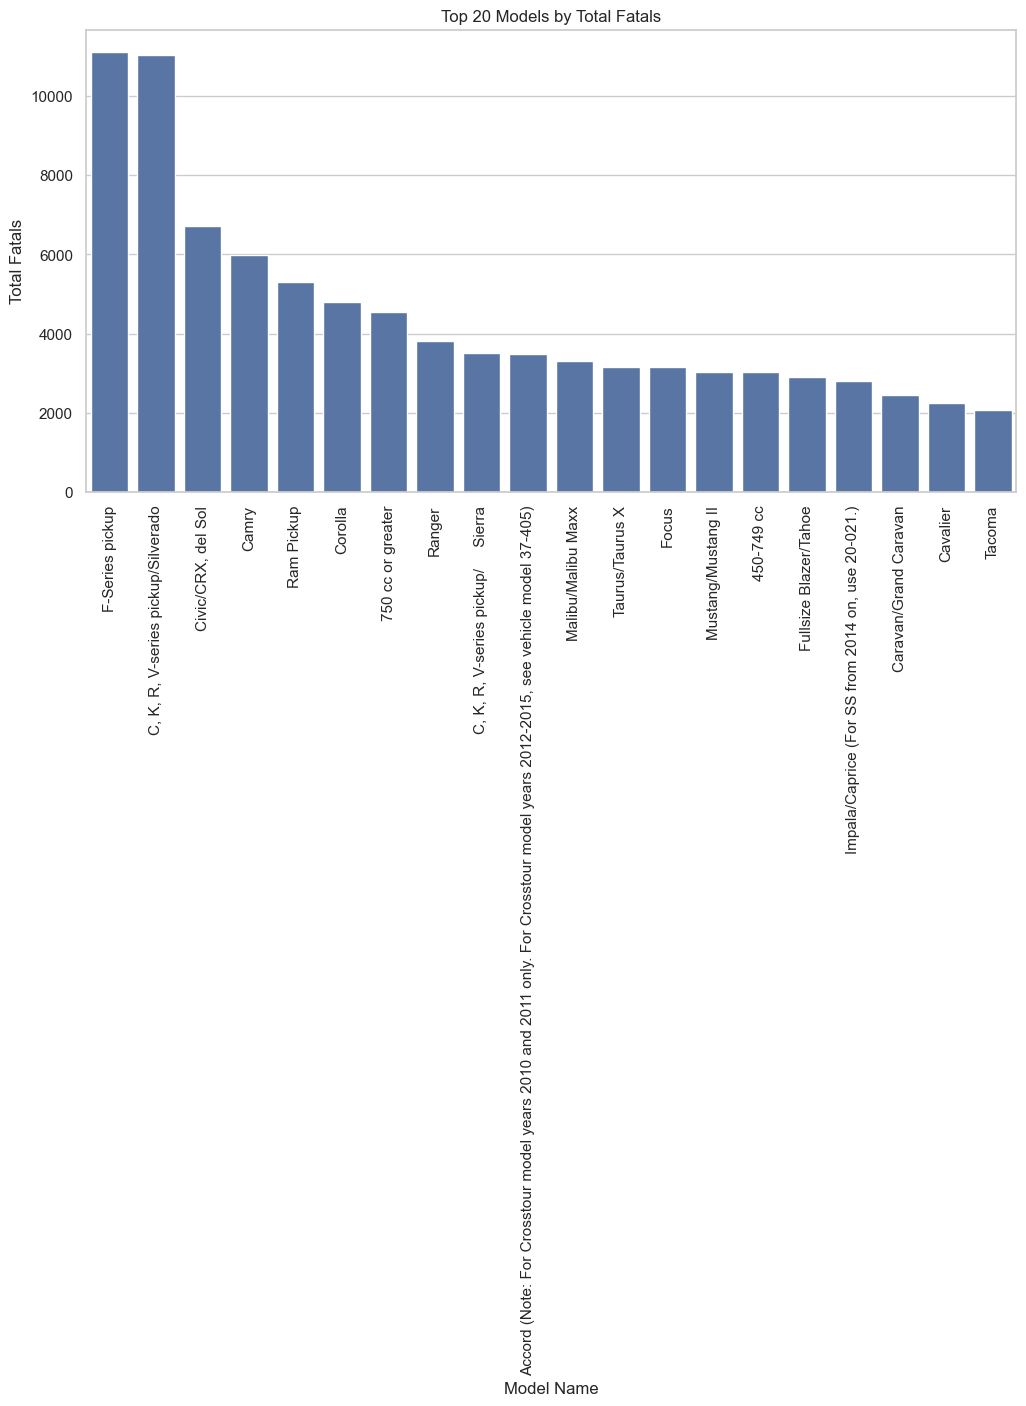

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the plotting style
sns.set(style="whitegrid")

# Get the top 20 models with the highest TotalFatals
top_df = df.nlargest(20, 'TotalFatals')
# Get the top 20 models with the highest TotalFatals
merged_top_df = merged_df.nlargest(20, 'TotalFatals')

# Create the bar plot for top 20 models
plt.figure(figsize=(12, 6))
sns.barplot(x='ModelName', y='TotalFatals', data=top_df)
plt.title('Top 20 Models by Total Fatals')
plt.xlabel('Model Name')
plt.ylabel('Total Fatals')
plt.xticks(rotation=90)  # Rotate model names for better visibility
plt.show()

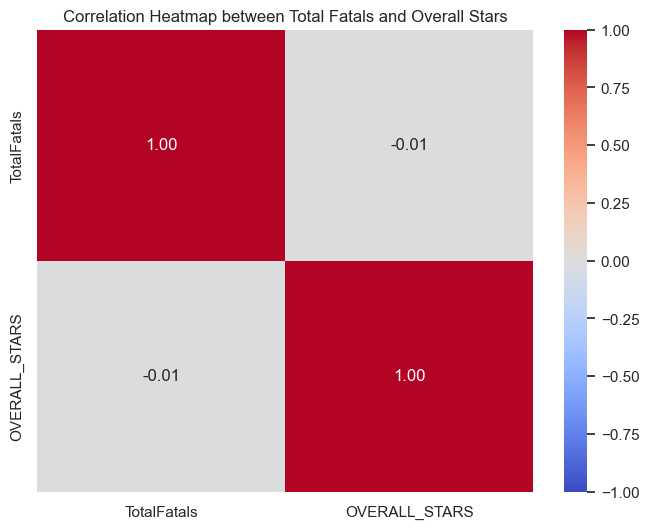

In [61]:
# Calculate the correlation matrix between 'TotalFatals' and 'OVERALL_STARS'
correlation_matrix = merged_df[['TotalFatals', 'OVERALL_STARS']].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Correlation Heatmap between Total Fatals and Overall Stars')
plt.show()


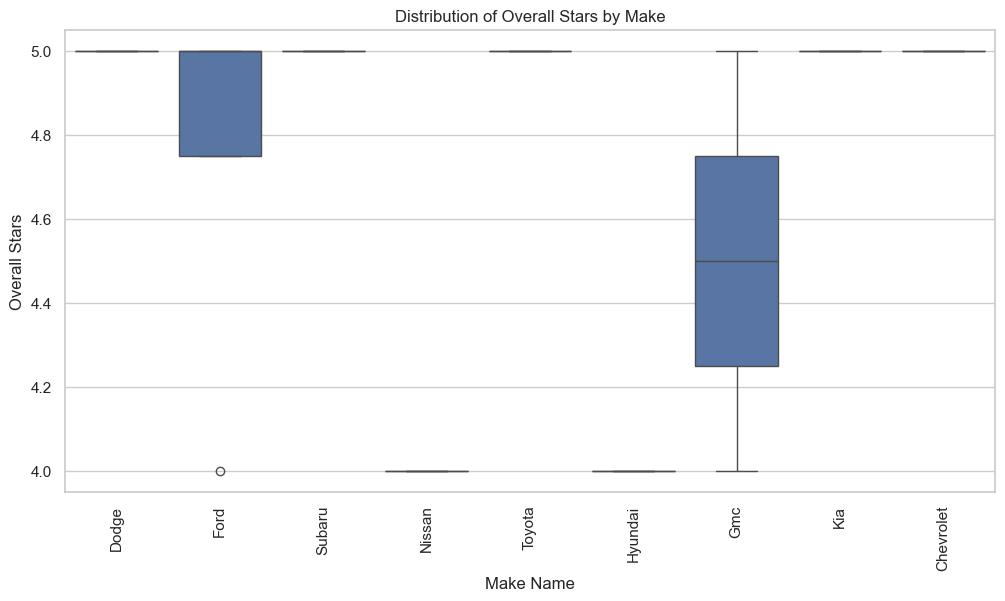

In [63]:
# 1. Boxplot: OVERALL_STARS by MakeName
plt.figure(figsize=(12, 6))
sns.boxplot(x='MAKE', y='OVERALL_STARS', data=merged_top_df)
plt.title('Distribution of Overall Stars by Make')
plt.xlabel('Make Name')
plt.ylabel('Overall Stars')
plt.xticks(rotation=90)  # Rotate make names for better visibility
plt.show()

/var/folders/bk/frkpdn794lg4tpwpn9vrl7w00000gn/T/ipykernel_61185/2874973672.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='MakeName', y='TotalFatals', data=top_df, palette='Blues_d')


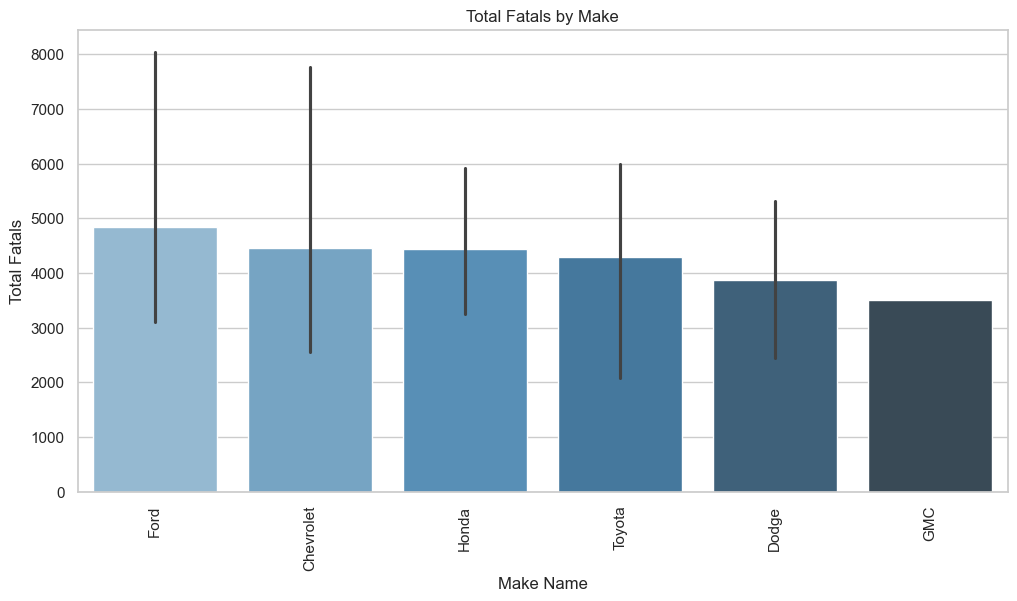

In [65]:
# 2. Bar Plot: TotalFatals by MakeName
plt.figure(figsize=(12, 6))
sns.barplot(x='MakeName', y='TotalFatals', data=top_df, palette='Blues_d')
plt.title('Total Fatals by Make')
plt.xlabel('Make Name')
plt.ylabel('Total Fatals')
plt.xticks(rotation=90)  # Rotate make names for better visibility
plt.show()

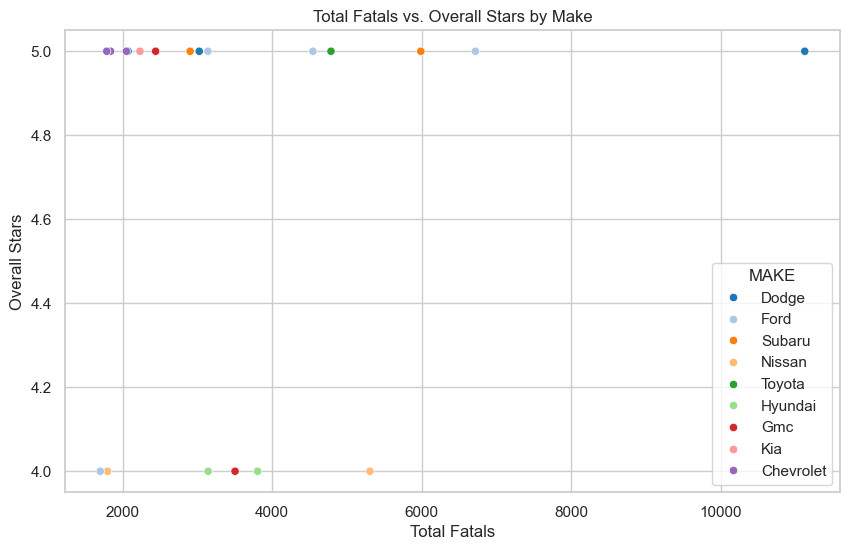

In [67]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TotalFatals', y='OVERALL_STARS', data=merged_top_df, hue='MAKE', palette='tab20', legend=True)
plt.title('Total Fatals vs. Overall Stars by Make')
plt.xlabel('Total Fatals')
plt.ylabel('Overall Stars')
plt.show()

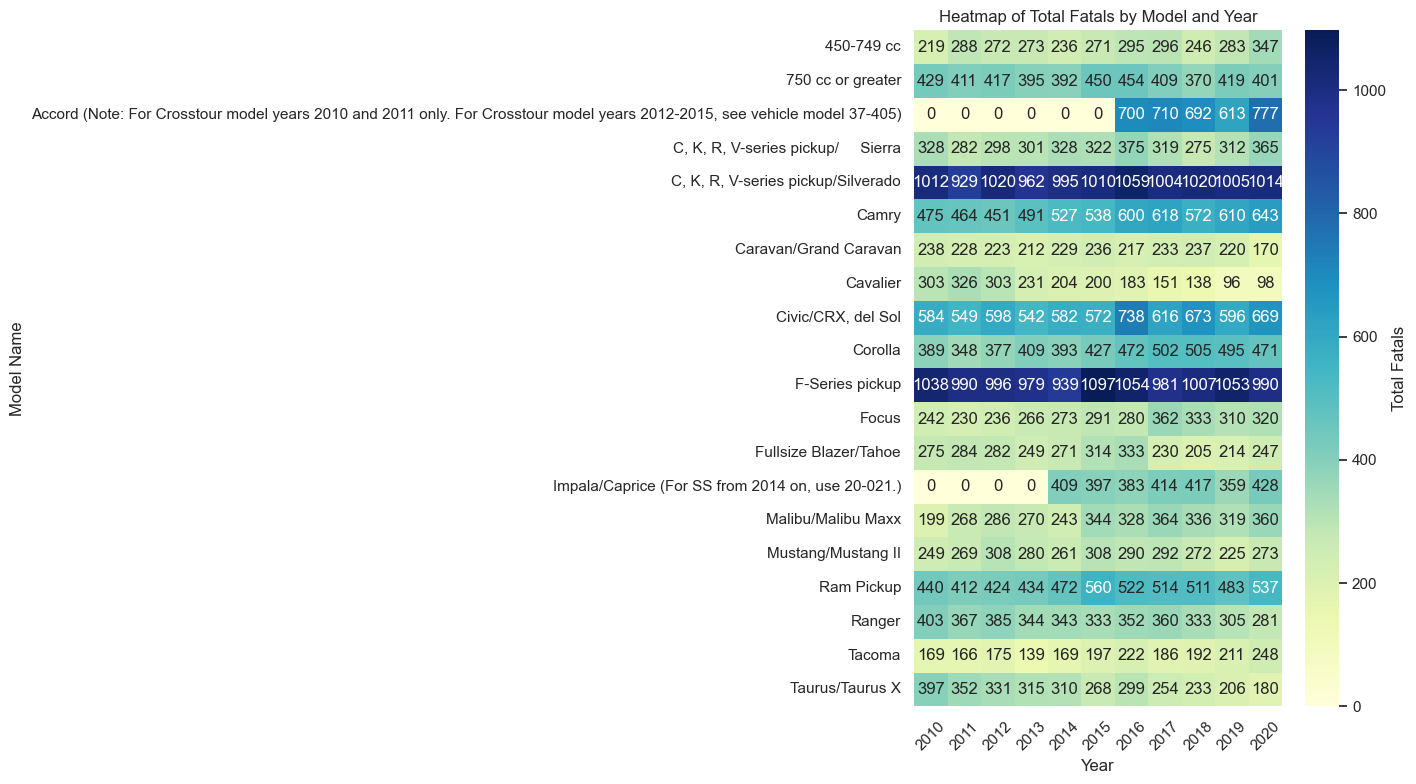

In [69]:
heatmap_data = top_df.groupby('ModelName')[year_columns].sum()

plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='d', cbar_kws={'label': 'Total Fatals'})
plt.title('Heatmap of Total Fatals by Model and Year')
plt.xlabel('Year')
plt.ylabel('Model Name')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

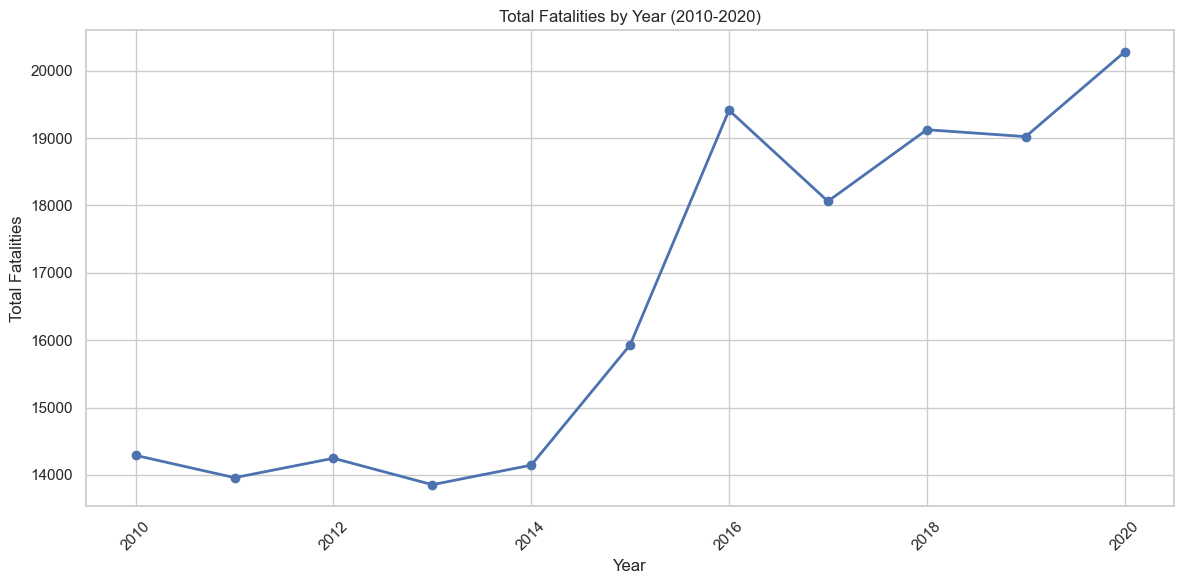

In [81]:
# Extract the year columns (2010-2020)
year_columns = [str(year) for year in range(2010, 2021)]

# Sum the fatalities for each year (sum of TotalFatals for each year)
total_fatals_by_year = df[year_columns].sum()

# Plot the line graph
plt.figure(figsize=(12, 6))
total_fatals_by_year.plot(kind='line', marker='o', color='b', linestyle='-', linewidth=2, markersize=6)

plt.title('Total Fatalities by Year (2010-2020)')
plt.xlabel('Year')
plt.ylabel('Total Fatalities')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

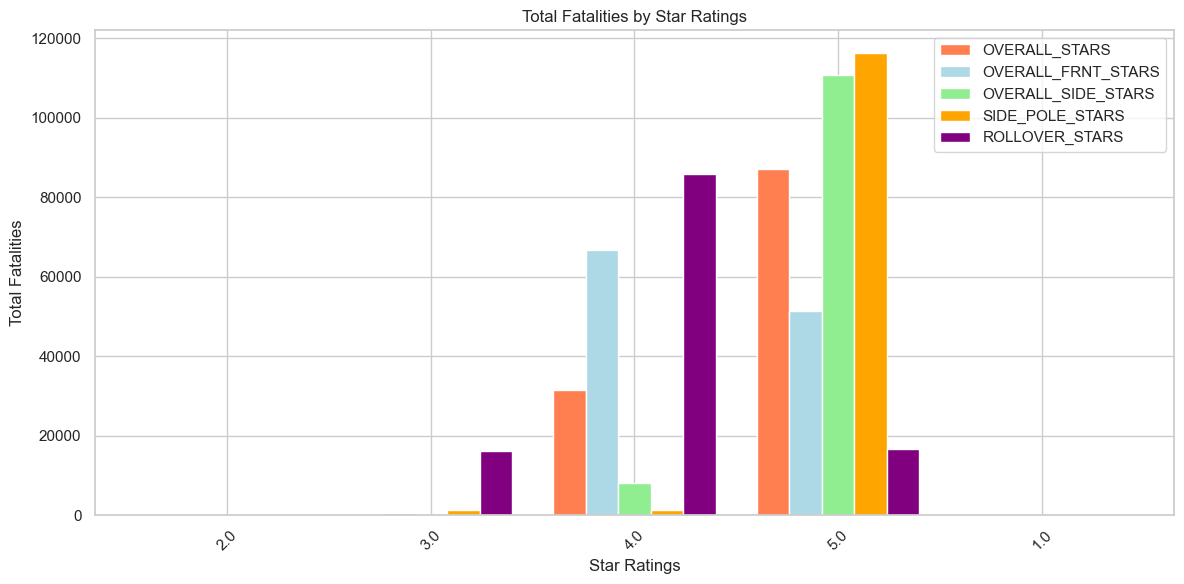

In [79]:
# Define the star columns
star_columns = ['OVERALL_STARS', 'OVERALL_FRNT_STARS', 'OVERALL_SIDE_STARS', 'SIDE_POLE_STARS', 'ROLLOVER_STARS']

# Create a list to store the summed fatalities by star column
fatalities_by_star = []

# Loop over each star column
for star_column in star_columns:
    # Group by the unique star ratings and sum the fatalities
    fatalities = merged_df.groupby(star_column)['TotalFatals'].sum()
    
    # Add the summed fatalities to the list
    fatalities_by_star.append(fatalities)

# Plot the bar graph for each star column
plt.figure(figsize=(12, 6))

# Combine all the fatalities into a single DataFrame
combined_fatalities = pd.concat(fatalities_by_star, axis=1)
combined_fatalities.columns = star_columns  # Label the columns appropriately

# Define unique colors for each star column
colors = ['coral', 'lightblue', 'lightgreen', 'orange', 'purple']

# Plot with custom colors
combined_fatalities.plot(kind='bar', figsize=(12, 6), width=0.8, color=colors)

plt.title('Total Fatalities by Star Ratings')
plt.xlabel('Star Ratings')
plt.ylabel('Total Fatalities')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()